#1. Importação das Bibliotecas

Descrição:
Neste bloco, importamos as bibliotecas essenciais para manipulação e visualização de dados. pandas e numpy são usados para manipulação de dados, enquanto matplotlib e statsmodels ajudam na visualização e análise de séries temporais.



In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


In [318]:
#!pip install statsforecast

#2. Carregamento e Visualização Inicial dos Dados

Descrição:
Carregamos os dados históricos do Ibovespa de um arquivo CSV. Em seguida, adicionamos uma coluna chamada 'Chave' para identificar os dados. As funções info(), head() e tail() são usadas para obter uma visão geral do DataFrame, incluindo os tipos de dados e as primeiras e últimas linhas.

In [319]:
dados_ibv = pd.read_csv('/content/Dados_Historicos_Ibovespa.csv', parse_dates=['Data'])

<ipython-input-319-3defcd01e7c9>:1: UserWarning:

Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



In [320]:
dados_ibv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      1246 non-null   datetime64[ns]
 1   Último    1246 non-null   float64       
 2   Abertura  1246 non-null   float64       
 3   Máxima    1246 non-null   float64       
 4   Mínima    1246 non-null   float64       
 5   Vol.      1246 non-null   object        
 6   Var%      1246 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 68.3+ KB


In [321]:
print(dados_ibv.head(5))

        Data   Último  Abertura   Máxima   Mínima   Vol.    Var%
0 2024-07-19  127.616   127.652  128.360  127.413  7,62B  -0,03%
1 2024-07-18  127.652   129.450  129.454  127.523  7,59B  -1,39%
2 2024-07-17  129.450   129.112  129.658  128.741  6,67B   0,26%
3 2024-07-16  129.110   129.322  129.521  128.761  6,82B  -0,16%
4 2024-07-15  129.321   128.898  129.485  128.723  5,83B   0,33%


In [322]:
print(dados_ibv.tail(5))

           Data   Último  Abertura   Máxima   Mínima   Vol.    Var%
1241 2019-07-25  102.655   104.119  104.440  102.390  5,98M  -1,41%
1242 2019-07-24  104.120   103.707  104.570  103.707  5,02M   0,40%
1243 2019-07-23  103.704   103.949  104.430  103.518  4,18M  -0,24%
1244 2019-07-22  103.949   103.452  104.278  103.452  3,57M   0,48%
1245 2019-07-19  103.452   104.716  104.723  103.388  3,59M  -1,21%


#3. Preparação dos Dados

Descrição:
Selecionamos e renomeamos as colunas relevantes do DataFrame para preparar os dados para modelagem. As colunas 'Data' e 'Último' são renomeadas para 'ds' e 'y', respectivamente, e a coluna 'Chave' para 'unique_id'. Convertendo 'ds' para o tipo datetime e 'unique_id' para string garante a consistência dos tipos de dados.

In [323]:
# Preparar DataFrame
dados_ibv['Chave'] = 'ibv'
df_1 = dados_ibv[['Data', 'Chave', 'Último']]
df_1 = df_1.rename(columns={'Data': 'ds', 'Último': 'y', 'Chave': 'unique_id'})

##4. Reindexação e Preenchimento de Valores Faltantes

Descrição:
Criamos um intervalo completo de datas para todos os dias úteis entre a primeira e a última data do DataFrame. Reindexamos o DataFrame original para incluir todos esses dias úteis e utilizamos o método ffill() para preencher valores faltantes com o último valor conhecido, garantindo que não haja lacunas nos dados.



In [324]:
# Criar intervalo completo de datas
start_date = df_1['ds'].min()
end_date = df_1['ds'].max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='B')  # Frequência de dias úteis

In [325]:
# Reindexar o DataFrame original para incluir todos os dias úteis
df_1 = df_1.set_index('ds').reindex(all_dates).rename_axis('ds').reset_index()

In [326]:
# Preencher valores faltantes com o último valor conhecido (forward fill)
df_1['y'] = df_1['y'].ffill()

In [327]:
# Definir a coluna 'unique_id'
df_1['unique_id'] = 'ibv'

#5. Visualização dos Dados Preenchidos

Descrição:
Criamos uma visualização dos dados preenchidos para garantir que o preenchimento foi feito corretamente. O gráfico mostra a evolução dos preços de fechamento da bolsa nos últimos cinco anos, com ajustes na aparência para melhorar a legibilidad

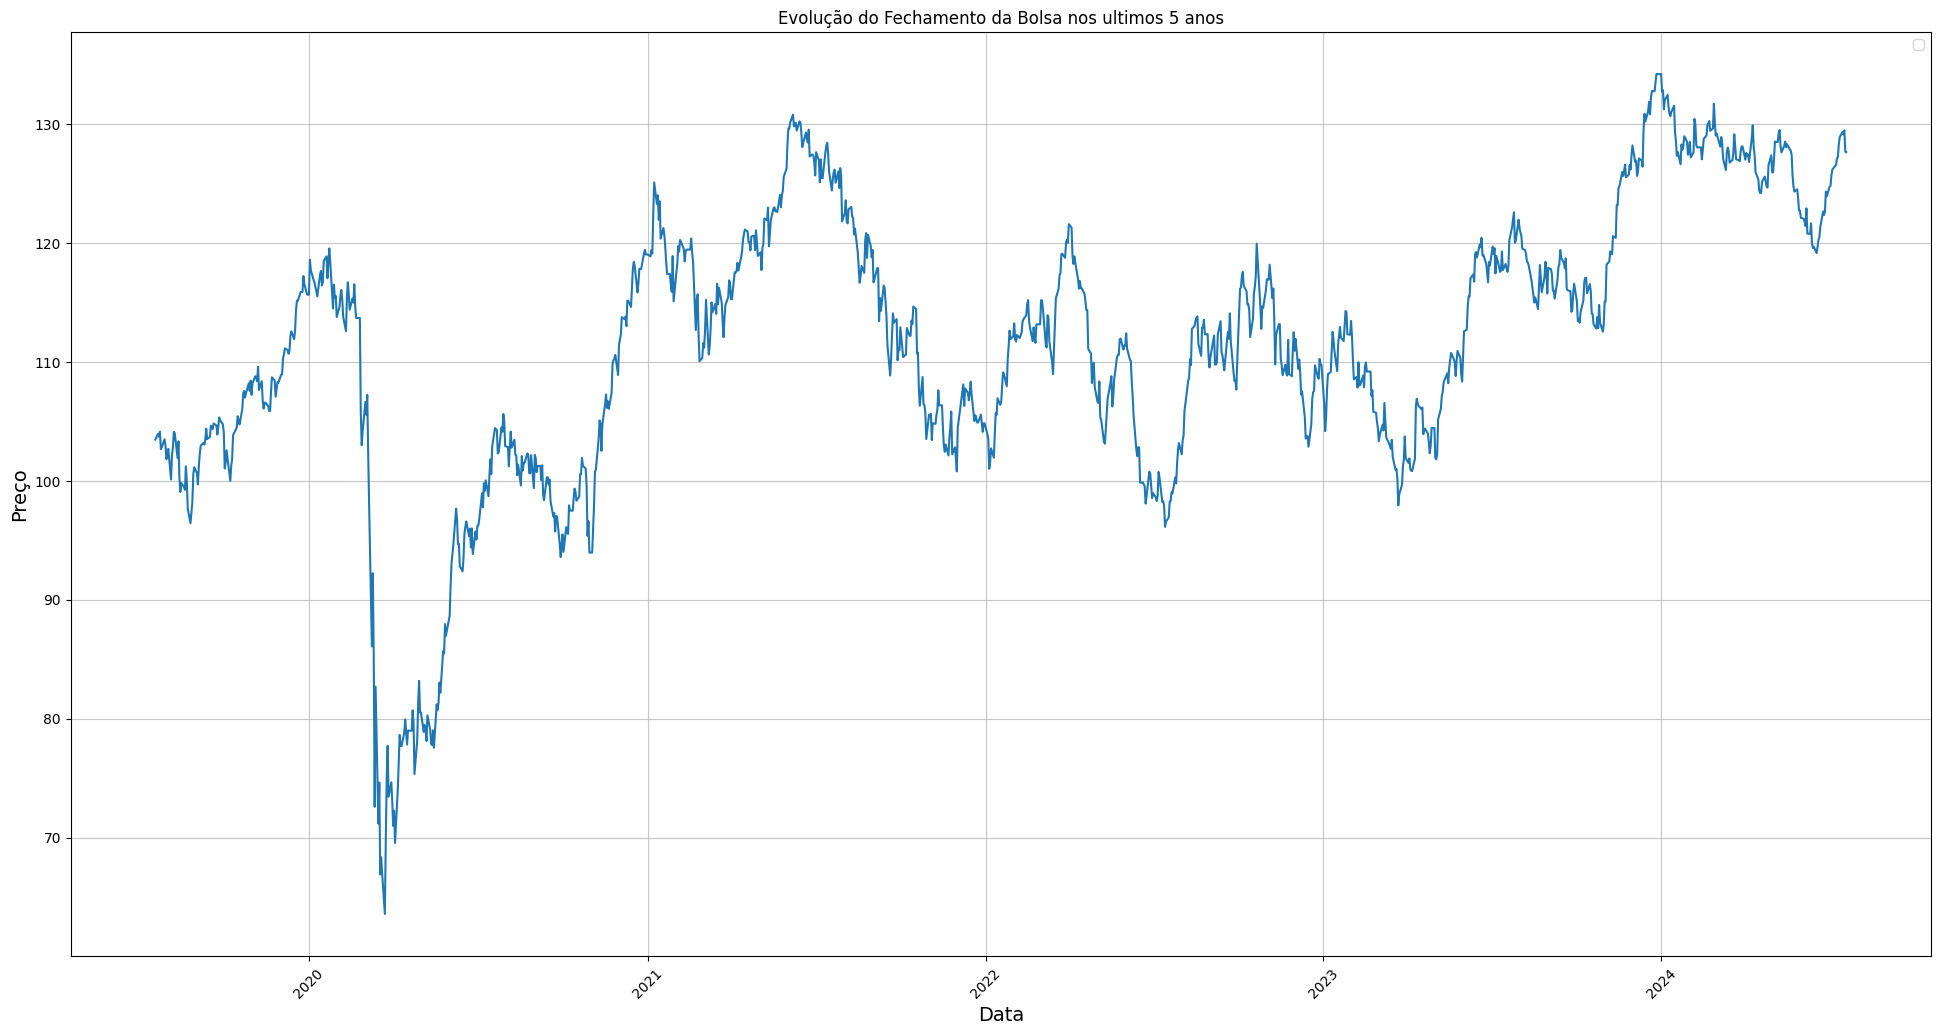

In [328]:
# Visualizar o DataFrame completo para garantir que os dados foram preenchidos corretamente
plt.figure(figsize=(24, 12))
plt.plot(df_1['ds'], df_1['y'])
plt.xlabel('Data', fontsize=14)  # Aumentar o tamanho da fonte dos rótulos dos eixos
plt.ylabel('Preço', fontsize=14)
plt.title('Evolução do Fechamento da Bolsa nos ultimos 5 anos')
plt.grid(True, linestyle='-', alpha=0.7)  # Ajustar o estilo da grade para linhas contínuas
plt.xticks(rotation=45)  # Rotacionar os rótulos do eixo x para melhor legibilidade
plt.legend()
plt.show()

##6. Definição da Função WMAPE



Descrição:
Definimos uma função para calcular o WMAPE (Weighted Mean Absolute Percentage Error), uma métrica usada para avaliar a precisão das previsões.

In [329]:

def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

#7. Visualização das Previsões e Cálculo do WMAPE#

Descrição:

Utilizamos a biblioteca statsforecast para criar previsões com modelos como Naive, SeasonalNaive, WindowAverage, SeasonalWindowAverage e AutoARIMA. Para visualizar essas previsões, empregamos a biblioteca plotly.graph_objects para gerar gráficos interativos que mostram tanto os valores reais quanto as previsões, além dos intervalos de confiança quando disponíveis. O WMAPE de cada modelo é calculado e exibido para avaliar a precisão das previsões

In [330]:

from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, WindowAverage, SeasonalWindowAverage, AutoARIMA
import plotly.graph_objects as go


In [338]:

# Dividir dados em treino e validação
train = df_1.loc[df_1['ds']  <   '2023-01-19']
valid = df_1.loc[(df_1['ds'] >=  '2023-01-19') & (df_1['ds'] <= '2024-07-19')]
h = valid['ds'].nunique()

# Ajuste os modelos
model = StatsForecast(models=[Naive(),
                              SeasonalNaive(season_length=7),
                              WindowAverage(window_size=7),
                              SeasonalWindowAverage(window_size=2, season_length=7),
                              AutoARIMA(season_length=7)],
                      freq='B', n_jobs=-1)
model.fit(train)

p = model.predict(h=h)
p = p.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

# Previsões
forecast_df = model.predict(h=h)
forecast_df = forecast_df.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

# Para cada modelo, cria gráficos interativos
for model_ in ['Naive', 'SeasonalNaive', 'WindowAverage', 'SeasWA', 'AutoARIMA']:
    fig = go.Figure()
    for family in ['ibv']:
        df_family = p[p['unique_id'] == family]

        # Adiciona a linha real
        fig.add_trace(go.Scatter(x=df_family['ds'], y=df_family['y'],
                                 mode='lines',
                                 name='y',
                                 line=dict(width=2)))

        # Adiciona a linha do modelo
        if model_ == 'AutoARIMA':
            if 'AutoARIMA' in forecast_df.columns:
                fig.add_trace(go.Scatter(x=forecast_df['ds'], y=forecast_df['AutoARIMA'],
                                         mode='lines',
                                         name='AutoARIMA'))
        else:
            if model_ in df_family.columns:
                fig.add_trace(go.Scatter(x=df_family['ds'], y=df_family[model_],
                                         mode='lines',
                                         name=model_))
            else:
                print(f"Coluna para o modelo {model_} não encontrada em df_family")

        # Verifica se as colunas de intervalos de confiança existem
        if f'{model_}-lo-90' in df_family.columns and f'{model_}-hi-90' in df_family.columns:
            fig.add_trace(go.Scatter(x=df_family['ds'],
                                     y=df_family[f'{model_}-lo-90'],
                                     fill='tonexty',
                                     fillcolor='rgba(255, 165, 0, 0.2)',
                                     mode='lines',
                                     name=f'{model_} - 90% lo',
                                     line=dict(width=0, color='rgba(255, 165, 0, 0.2)')))
            fig.add_trace(go.Scatter(x=df_family['ds'],
                                     y=df_family[f'{model_}-hi-90'],
                                     fill='tonexty',
                                     fillcolor='rgba(255, 165, 0, 0.2)',
                                     mode='lines',
                                     name=f'{model_} - 90% hi',
                                     line=dict(width=0, color='rgba(255, 165, 0, 0.2)')))

    fig.update_layout(title=f'{model_} Forecast',
                      xaxis_title='Date',
                      yaxis_title='Sales',
                      legend_title='Legend',
                      autosize=True)

    fig.show()

    # Cálculo e impressão do WMAPE
    if model_ == 'AutoARIMA':
        wmape_ = wmape(p['y'].values, forecast_df['AutoARIMA'].values)
    else:
        wmape_ = wmape(p['y'].values, p.get(model_, pd.Series([])).values)

    print(f'{model_} WMAPE: {wmape_:.2%}')


/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



Naive WMAPE: 8.23%


SeasonalNaive WMAPE: 8.68%


WindowAverage WMAPE: 8.68%


SeasWA WMAPE: 9.67%


AutoARIMA WMAPE: 8.07%


In [337]:
# Dividir dados em treino e validação
train = df_1.loc[df_1['ds']  <   '2024-04-19']
valid = df_1.loc[(df_1['ds'] >=  '2024-04-19') & (df_1['ds'] <= '2024-07-19')]
h = valid['ds'].nunique()

# Ajuste os modelos
model = StatsForecast(models=[Naive(),
                              SeasonalNaive(season_length=7),
                              WindowAverage(window_size=7),
                              SeasonalWindowAverage(window_size=2, season_length=7),
                              AutoARIMA(season_length=7)],
                      freq='B', n_jobs=-1)
model.fit(train)

p = model.predict(h=h)
p = p.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

# Previsões
forecast_df = model.predict(h=h)
forecast_df = forecast_df.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

# Para cada modelo, cria gráficos interativos
for model_ in ['Naive', 'SeasonalNaive', 'WindowAverage', 'SeasWA', 'AutoARIMA']:
    fig = go.Figure()
    for family in ['ibv']:
        df_family = p[p['unique_id'] == family]

        # Adiciona a linha real
        fig.add_trace(go.Scatter(x=df_family['ds'], y=df_family['y'],
                                 mode='lines',
                                 name='y',
                                 line=dict(width=2)))

        # Adiciona a linha do modelo
        if model_ == 'AutoARIMA':
            if 'AutoARIMA' in forecast_df.columns:
                fig.add_trace(go.Scatter(x=forecast_df['ds'], y=forecast_df['AutoARIMA'],
                                         mode='lines',
                                         name='AutoARIMA'))
        else:
            if model_ in df_family.columns:
                fig.add_trace(go.Scatter(x=df_family['ds'], y=df_family[model_],
                                         mode='lines',
                                         name=model_))
            else:
                print(f"Coluna para o modelo {model_} não encontrada em df_family")

        # Verifica se as colunas de intervalos de confiança existem
        if f'{model_}-lo-90' in df_family.columns and f'{model_}-hi-90' in df_family.columns:
            fig.add_trace(go.Scatter(x=df_family['ds'],
                                     y=df_family[f'{model_}-lo-90'],
                                     fill='tonexty',
                                     fillcolor='rgba(255, 165, 0, 0.2)',
                                     mode='lines',
                                     name=f'{model_} - 90% lo',
                                     line=dict(width=0, color='rgba(255, 165, 0, 0.2)')))
            fig.add_trace(go.Scatter(x=df_family['ds'],
                                     y=df_family[f'{model_}-hi-90'],
                                     fill='tonexty',
                                     fillcolor='rgba(255, 165, 0, 0.2)',
                                     mode='lines',
                                     name=f'{model_} - 90% hi',
                                     line=dict(width=0, color='rgba(255, 165, 0, 0.2)')))

    fig.update_layout(title=f'{model_} Forecast',
                      xaxis_title='Date',
                      yaxis_title='Sales',
                      legend_title='Legend',
                      autosize=True)

    fig.show()

    # Cálculo e impressão do WMAPE
    if model_ == 'AutoARIMA':
        wmape_ = wmape(p['y'].values, forecast_df['AutoARIMA'].values)
    else:
        wmape_ = wmape(p['y'].values, p.get(model_, pd.Series([])).values)

    print(f'{model_} WMAPE: {wmape_:.2%}')

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



Naive WMAPE: 2.18%


SeasonalNaive WMAPE: 2.23%


WindowAverage WMAPE: 2.06%


SeasWA WMAPE: 2.22%


AutoARIMA WMAPE: 2.34%


In [339]:
# Dividir dados em treino e validação

train = df_1.loc[df_1['ds']  <   '2024-06-19']
valid = df_1.loc[(df_1['ds'] >=  '2024-06-19') & (df_1['ds'] <= '2024-07-19')]
h = valid['ds'].nunique()

# Ajuste os modelos
model = StatsForecast(models=[Naive(),
                              SeasonalNaive(season_length=7),
                              WindowAverage(window_size=7),
                              SeasonalWindowAverage(window_size=2, season_length=7),
                              AutoARIMA(season_length=7)],
                      freq='B', n_jobs=-1)
model.fit(train)

p = model.predict(h=h)
p = p.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

# Previsões
forecast_df = model.predict(h=h)
forecast_df = forecast_df.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

# Para cada modelo, cria gráficos interativos
for model_ in ['Naive', 'SeasonalNaive', 'WindowAverage', 'SeasWA', 'AutoARIMA']:
    fig = go.Figure()
    for family in ['ibv']:
        df_family = p[p['unique_id'] == family]

        # Adiciona a linha real
        fig.add_trace(go.Scatter(x=df_family['ds'], y=df_family['y'],
                                 mode='lines',
                                 name='y',
                                 line=dict(width=2)))

        # Adiciona a linha do modelo
        if model_ == 'AutoARIMA':
            if 'AutoARIMA' in forecast_df.columns:
                fig.add_trace(go.Scatter(x=forecast_df['ds'], y=forecast_df['AutoARIMA'],
                                         mode='lines',
                                         name='AutoARIMA'))
        else:
            if model_ in df_family.columns:
                fig.add_trace(go.Scatter(x=df_family['ds'], y=df_family[model_],
                                         mode='lines',
                                         name=model_))
            else:
                print(f"Coluna para o modelo {model_} não encontrada em df_family")

        # Verifica se as colunas de intervalos de confiança existem
        if f'{model_}-lo-90' in df_family.columns and f'{model_}-hi-90' in df_family.columns:
            fig.add_trace(go.Scatter(x=df_family['ds'],
                                     y=df_family[f'{model_}-lo-90'],
                                     fill='tonexty',
                                     fillcolor='rgba(255, 165, 0, 0.2)',
                                     mode='lines',
                                     name=f'{model_} - 90% lo',
                                     line=dict(width=0, color='rgba(255, 165, 0, 0.2)')))
            fig.add_trace(go.Scatter(x=df_family['ds'],
                                     y=df_family[f'{model_}-hi-90'],
                                     fill='tonexty',
                                     fillcolor='rgba(255, 165, 0, 0.2)',
                                     mode='lines',
                                     name=f'{model_} - 90% hi',
                                     line=dict(width=0, color='rgba(255, 165, 0, 0.2)')))

    fig.update_layout(title=f'{model_} Forecast',
                      xaxis_title='Date',
                      yaxis_title='Sales',
                      legend_title='Legend',
                      autosize=True)

    fig.show()

    # Cálculo e impressão do WMAPE
    if model_ == 'AutoARIMA':
        wmape_ = wmape(p['y'].values, forecast_df['AutoARIMA'].values)
    else:
        wmape_ = wmape(p['y'].values, p.get(model_, pd.Series([])).values)

    print(f'{model_} WMAPE: {wmape_:.2%}')

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



Naive WMAPE: 4.68%


SeasonalNaive WMAPE: 4.39%


WindowAverage WMAPE: 4.35%


SeasWA WMAPE: 3.73%


AutoARIMA WMAPE: 4.84%


In [334]:

# Dividir dados em treino e validação

train = df_1.loc[df_1['ds']  <   '2024-07-08']
valid = df_1.loc[(df_1['ds'] >=  '2024-07-08') & (df_1['ds'] <= '2024-07-19')]
h = valid['ds'].nunique()

# Ajuste os modelos
model = StatsForecast(models=[Naive(),
                              SeasonalNaive(season_length=7),
                              WindowAverage(window_size=7),
                              SeasonalWindowAverage(window_size=2, season_length=7),
                              AutoARIMA(season_length=7)],
                      freq='B', n_jobs=-1)
model.fit(train)

p = model.predict(h=h)
p = p.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

# Previsões
forecast_df = model.predict(h=h)
forecast_df = forecast_df.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

# Para cada modelo, cria gráficos interativos
for model_ in ['Naive', 'SeasonalNaive', 'WindowAverage', 'SeasWA', 'AutoARIMA']:
    fig = go.Figure()
    for family in ['ibv']:
        df_family = p[p['unique_id'] == family]

        # Adiciona a linha real
        fig.add_trace(go.Scatter(x=df_family['ds'], y=df_family['y'],
                                 mode='lines',
                                 name='y',
                                 line=dict(width=2)))

        # Adiciona a linha do modelo
        if model_ == 'AutoARIMA':
            if 'AutoARIMA' in forecast_df.columns:
                fig.add_trace(go.Scatter(x=forecast_df['ds'], y=forecast_df['AutoARIMA'],
                                         mode='lines',
                                         name='AutoARIMA'))
        else:
            if model_ in df_family.columns:
                fig.add_trace(go.Scatter(x=df_family['ds'], y=df_family[model_],
                                         mode='lines',
                                         name=model_))
            else:
                print(f"Coluna para o modelo {model_} não encontrada em df_family")

        # Verifica se as colunas de intervalos de confiança existem
        if f'{model_}-lo-90' in df_family.columns and f'{model_}-hi-90' in df_family.columns:
            fig.add_trace(go.Scatter(x=df_family['ds'],
                                     y=df_family[f'{model_}-lo-90'],
                                     fill='tonexty',
                                     fillcolor='rgba(255, 165, 0, 0.2)',
                                     mode='lines',
                                     name=f'{model_} - 90% lo',
                                     line=dict(width=0, color='rgba(255, 165, 0, 0.2)')))
            fig.add_trace(go.Scatter(x=df_family['ds'],
                                     y=df_family[f'{model_}-hi-90'],
                                     fill='tonexty',
                                     fillcolor='rgba(255, 165, 0, 0.2)',
                                     mode='lines',
                                     name=f'{model_} - 90% hi',
                                     line=dict(width=0, color='rgba(255, 165, 0, 0.2)')))

    fig.update_layout(title=f'{model_} Forecast',
                      xaxis_title='Date',
                      yaxis_title='Sales',
                      legend_title='Legend',
                      autosize=True)

    fig.show()

    # Cálculo e impressão do WMAPE
    if model_ == 'AutoARIMA':
        wmape_ = wmape(p['y'].values, forecast_df['AutoARIMA'].values)
    else:
        wmape_ = wmape(p['y'].values, p.get(model_, pd.Series([])).values)

    print(f'{model_} WMAPE: {wmape_:.2%}')

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:492: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



Naive WMAPE: 1.45%


SeasonalNaive WMAPE: 2.53%


WindowAverage WMAPE: 2.35%


SeasWA WMAPE: 4.06%


AutoARIMA WMAPE: 1.21%
